# Homework 4 - Does basic house information reflect house's description?
## Group 11 -  Riccardo Cervelli, Kentaro Kato, Pavan kumar Alikana.

![AirBnb](https://static.designboom.com/wp-content/uploads/2014/12/peter-pichler-architecture-mirror-houses-designboom-09.jpg)

The goal of this section of  HW4 was perform a clustering analysis of house announcements in Rome from Immobiliare.it. We had to implement two clustering and compare the results we got. We created two datasets and each of them is filled by data that we scraped by https://www.immobiliare.it, but you can check also from  [here](https://www.immobiliare.it).

### Load required python packages

In [2]:
#%%writefile code/load_packages.py
import time

# For webscrapping
import requests
from bs4 import BeautifulSoup

from os.path import join as pjoin
import os
from pathlib import Path

import pandas as pd
import numpy as np
import html
from lxml import html

# For persisting indexes in an external file
import pickle
import math
import nltk

# For word tokenization
from nltk.tokenize import RegexpTokenizer

# For stop words list
from nltk.corpus import stopwords

# For word stemming
from nltk.stem.snowball import SnowballStemmer
from sklearn.cluster import KMeans
from wordcloud import WordCloud
import matplotlib.pyplot as plt

### Load utility functions to be used through out the code

We choose to define all our functions at the beginning of this Section, because is more convenient and more simple to read for you!
Here you can chek our functions.

In [3]:
#%%writefile code/utilities.py

# Common utility functions

def extract_number(n):
    n = n.replace('.', '')
    n = n.replace('+', '')
    n_list = [str(s) for s in n.split() if s.isdigit()]

    s = ''.join(n_list).strip()
    
    if not s:
        s = 0

    return int(s)

# Utility functions for reading and writing files using pickel python package
def read_file_from_pickle(file):
    file_content = {}
    
    if file.is_file():
        with open(file, "rb") as f:
            file_content = pickle.load(f)
            f.close()
    
    return file_content

def write_file_to_pickle(file, content):
    with open(file, "wb") as f:
        pickle.dump(content, f)
        f.close()

# Apply Jaccard similarity to find out 3 most similar clusters
def get_jaccard(a, b):
    c = a.intersection(b)
    return float(len(c)) / (len(a) + len(b) - len(c))


# Utility functions for clustering and wordcloud

def get_listing_content(i, sflag):
    listing_words = ''
    if sflag:
        listing_words = listing_content_persist[i]
    else:
        listing_id = listing_index_persist['listing_ids'][i]
        listing_data = listings_persist[listing_id]
        listing_words = listing_data['description']

    return listing_words + ' '

def get_wc_save_path(i, sflag):

    folder_prefix = 'wordcloud/'
    f_name_prefix = ''

    if(sflag):
        f_name_prefix = "cluster"
    else:
        f_name_prefix = "cluster_all"

    return folder_prefix + f_name_prefix + str(i)


def compare_clusters(c1, c2):

    jac_score_list = []
    comb_list = []
    cmp_output = {}

    for i in range(len(c1)):
        for j in range(len(c2)):
            # Adding the score of each cluster combination to jac_score_list
            jac_score_list.append(get_jaccard(set(c1[i]), set(c2[j])))
            comb_list.append([i,j])

    cmp_output['score_list'] = jac_score_list
    cmp_output['comb_list'] = comb_list
    
    return cmp_output


def get_similar_clusters(top_3_list, c1, c2):
    similar_clusters = []

    for t in top_3_list:
        t_list = list(t)
        c_list_1 = c1[t_list[1][0]]
        c_list_2 = c2[t_list[1][1]]

        s_list = list(set(c_list_1 + c_list_2))

        similar_clusters.append(s_list)

    return similar_clusters

## Load the data persisted using pickel library:

### We are using the following indexes - 

- listings.pkl - contains all the listings data as it was scrapped in the dictionary format of "listing_id": listing_obj

- listing_links.pkl - contains all the individual listing page hyperlinks to be scrapped separately (one time action)

- isting_index.pkl - contains all the listing ids(extracted from the listing pages while scrapping), to preserve the ordering of listings while building information and description datasets

- listing_content.pkl - contains the data from all individual listings with all the stop words removed, we are using this to find tfidf values of all the words in the vocabulary.pkl file

- vocabulary.pkl - contains metadata of the words in the following format (eg: "123": [334,4545,645]) where 123 is the word_id taken from words.pkl and 334,4545,645 are listing ids in which that word is present

- words.pkl - contains all the words present accross all the listings in the following format (eg: "house": "123")

- iindex_tf_idf.pkl - contains the dictionary of tfidf values of all the words in words.pkl

- information_dataset.pkl - Holds the information data set in the format mentioned in the homework text

- description_dataset.pkl -  Holds the description data set in the format mentioned in the homework text





In [4]:
#%%writefile code/load_data.py

# Import all the persisted data at once
# Data to import: 
# Listing data, Individual listing links, Listing Index 
# Words, Vocabulary, listing_content, iindex_tf_idf
# information_dataset, description_dataset

# Path to the current working directory to refer to all the files relatively
my_path = os.path.dirname(os.path.realpath('__file__'))

# Datastructures for holding the listings and other metadata
# Please create a directory(in your current working directory) with name 'indexes'  

#Holds individual listings data for the listing pages downloaded
listings_file = Path(os.path.join(my_path, "indexes/listings.pkl"))
listings_persist = {}

if listings_file.is_file():
    with open(listings_file, "rb") as listings:
        listings_persist = pickle.load(listings)
        listings.close()

#Holds the URLs of individual listings for extracting complete description of a particular listing
listing_links_file = Path(os.path.join(my_path, "indexes/listing_links.pkl"))
listing_links_persist = read_file_from_pickle(listing_links_file)


#Holds the order of individual listing
listing_index_file = Path(os.path.join(my_path, "indexes/listing_index.pkl"))
listing_index_persist = read_file_from_pickle(listing_index_file)
     

# Retrieving persisted information for listing content and word map (words and vocabulary)
content_file = Path(os.path.join(my_path, "indexes/listing_content.pkl"))
listing_content_persist = read_file_from_pickle(content_file)



vocabulary_file = Path(os.path.join(my_path, "indexes/vocabulary.pkl"))
vocabulary_persist = read_file_from_pickle(vocabulary_file)

words_file = Path(os.path.join(my_path, "indexes/words.pkl"))
words_persist = read_file_from_pickle(words_file)
        
index_file = Path(os.path.join(my_path, "indexes/iindex_tf_idf.pkl"))
iindex_tf_idf_persist = read_file_from_pickle(index_file)


# Information data set
information_ds_file = Path(os.path.join(my_path, "indexes/information_dataset.pkl"))
information_ds_persist = read_file_from_pickle(information_ds_file)

# Description data set - containing tf-idf values
description_ds_file = Path(os.path.join(my_path, "indexes/description_dataset.pkl"))
description_ds_persist = read_file_from_pickle(description_ds_file)

### Jaccard Similarity

In our previuos HW we used Cosine Similarity but now we used Jaccard. We show you how its works in a really simple way.

![jac](https://i0.wp.com/dataaspirant.com/wp-content/uploads/2015/04/jaccard_similariyt.png)

![sim](https://i1.wp.com/dataaspirant.com/wp-content/uploads/2015/04/jaccaard2.png)

# Scraping

We downloaded the files into folder with name data. Every group listing page has information about 25 listings, we downloaded 1000 pages to have a bigger sample.. The website that scraped is [here](https://www.immobiliare.it). In particular, we retrieve more thaa 10k announcements starting from this link. We used the Beautiful Soup library to parse the html file . But we used also time.sleep(t), where t is the number of seconds, to prevent the website block. 

In [5]:
#%%writefile code/group_listings_download.py

# Checking if the indexes exist
# Check the first file 
listing_page_file = Path(os.path.join(my_path, "indexes/listings.pkl"))

if listing_page_file.is_file() == False:

    # If there are no files then start downloading each html file with a delay of 3 seconds
    print('Downloading group listings pages...')
    
    url_root = 'https://www.immobiliare.it/vendita-case/roma/?criterio=rilevanza&pag='


    for i in range(1000):

        cur_url = url_root + str(i)

        cur_content = requests.get(cur_url)

        res_text = BeautifulSoup(cur_content.text, "lxml")

        cur_html_file= open("data/listing_" + str(i) + ".html", "w")
        cur_html_file.write(str(res_text))
        cur_html_file.close()
        
        # 3 seconds delay for the next page download attempt
        time.sleep(3)
else:
    print('Group listings pages already downloaded')

Group listings pages already downloaded


 Download individual listing page to update the full description of the listing, we downloaded 10000 individual listing pages and updated corresponding index file listings.pkl

Note: We downloaded the files in to folder with name listing_data

In [6]:
#%%writefile code/listings_download.py


# Downloading individual listings pages from the listing links persisted
# Checking if the indexes exist
# Check the first file 
listing_page_file = Path(os.path.join(my_path, "indexes/listings.pkl"))


if listing_page_file.is_file() == False:
    
    print('Downloading individual listing pages...')

    links_list = []

    if(len(listing_links_persist.keys()) != 0):

        # Getting listing page links
        for key in  listing_links_persist:
            cur_link = listing_links_persist[key]

            # Check if the link is relative
            # If yes make it absolute link
            # Need to add better checks here
            if(cur_link[0] == "/"):
                cur_link = "https://www.immobiliare.it" + cur_link

            links_list.append(cur_link)

        # Downloading the pages
        for i in range(690, len(links_list)):

            cur_url = links_list[i]

            cur_content = requests.get(cur_url)

            res_text = BeautifulSoup(cur_content.text, "lxml")

            cur_detail_file = os.path.join(my_path, "data_detail/listing_detail_" + str(i) + ".html")

            cur_html_file= open(cur_detail_file, "w")
            cur_html_file.write(str(res_text))
            cur_html_file.close()

            # Wait for 3 seconds before downloading the next page
            time.sleep(3)
else:
    print('Individual listing pages already downloaded')
    

Individual listing pages already downloaded


Here we used for web scrapping  BeautifulSoup library  for group listing and individual listing pages:


In [7]:
#%%writefile code/scrape_listings.py

# If this is True then the listing description is updated from 
# the individual pages
desc_flag = False

if(len(listing_index_persist.keys()) == 0):

    print("Indexes are being created")

    l_index = 0
    listing_index_persist['listing_ids'] = []

    # Every page has 25 listings so
    # 410*25 will be more than 10000 listings
    for i in range(1, 410):

        cur_listing_page = BeautifulSoup(open(os.path.join(my_path, 'data/listing_' + str(i) + '.html')), 'html.parser')

        listing_container = cur_listing_page.find(class_="annunci-list")
        
        # Need to improve exception handling in this loop
        for cur_listing in listing_container.find_all(class_=["listing-item", "js-row-detail"], recursive=False):

            listing_dict = {
                "id": "",
                "listing_id": "",
                "title": "",
                "price": 0,
                "locali": 0,
                "superficie": 0,
                "bagni": 0,
                "piano": 0,
                "immobile": "",
                "listing_link": "",
                "description": ""
            }

            listing_body = cur_listing.find(class_="listing-item_body")

            if(listing_body):

                listing_dict['id'] = l_index
                listing_dict['listing_id'] = cur_listing.get("data-id")

                listing_dict['title'] = listing_body.find(class_="titolo").text.strip()

                listing_dict["listing_link"] = listing_body.find("a", {"id": "link_ad_" + listing_dict['listing_id']}).get("href")

                listing_dict['description'] = listing_body.find(class_="descrizione").text.strip()

                # Extracting the listing features 
                listing_features = listing_body.find(class_=["listing-features", "list-piped"])

                listing_links_persist[listing_dict['listing_id']] = listing_dict["listing_link"]

                for cur_feature in listing_features.find_all(class_="lif__item", recursive=False):

                    feature_cls_list = cur_feature.get("class")

                    # Extract listing price
                    if 'lif__pricing' in feature_cls_list:
                        listing_dict['price'] = extract_number(cur_feature.text.strip())
                    else:
                        # Extract other features information
                        # @TODO: Need to refine locali to contain a list: example: 1-5 should be [1,2,3,4,5]
                        feature_name = cur_feature.find(class_="lif--muted")

                        # @TODO: Need to do this more efficiently
                        if(feature_name):
                            feature_name = feature_name.text.strip()

                            if feature_name in listing_dict:
                                feature_value = cur_feature.find(class_="text-bold").text.strip()
                                listing_dict[feature_name] = extract_number(feature_value)


                listing_index_persist['listing_ids'].append(listing_dict['listing_id'])

                l_index += 1
                listings_persist[listing_dict['listing_id']] = listing_dict


    # Remove duplicate listing entries
    listing_index_persist['listing_ids'] = list(set(listing_index_persist['listing_ids']))

    # Persist the listings object and dictionary using pickel library
    
    #Save listings data
    write_file_to_pickle(listings_file, listings_persist)

    #Save individual listings links data
    write_file_to_pickle(listing_links_file, listing_links_persist)

    #Save index of listings
    write_file_to_pickle(listing_index_file, listing_index_persist)

else:
    print("Indexes are already created")


#print("No of links:")
#print(len(listing_links_persist.keys()))

#print("No of listings:")
#print(len(listings_persist.keys()))

#print("No of listings in the listing index file:")
#print(len(listing_index_persist['listing_ids']))


if desc_flag:

    # Parse the detail pages 
    # And update the description of individual listings
    for i in range(len(listing_links_persist.keys())):
        cur_detail_page = BeautifulSoup(open(os.path.join(my_path, 'data_detail/listing_detail_' + str(i) + '.html')), 'html.parser')

        cur_page_contact = cur_detail_page.find('div',{"id":"up-contact-box"})
        if cur_page_contact:
            cur_page_elem = cur_page_contact.find(class_="info-agenzia")

            if cur_page_elem:
                cur_page_id = cur_page_elem.get("data-annuncio")

                cur_page_description =  cur_detail_page.find(class_="description-text")

                if cur_page_description:
                    cur_page_description = cur_page_description.text.strip()

                    cur_page_description = "".join(cur_page_description.splitlines())

                    if cur_page_id in listings_persist:
                        listings_persist[cur_page_id]['description'] = cur_page_description
                    else:
                        pass
                        #print("Page key not found in the persisted data")
                else:
                    pass
                    #print("Page Description not found")
            else:
                pass
                #print("Page ID not found")
        else:
            pass
            #print("Contact not found")

    #Save listings data with new content (complete listing description)
    write_file_to_pickle(listings_file, listings_persist)


Indexes are already created


##  Finally we can show you our Datasets!

### 1) Information

In [8]:
#%%writefile code/create_information_ds.py

#Preparing information data set
if(len(information_ds_persist.keys()) == 0):

    information_ds_persist['dataset'] = []

    # Get the persisted listings data
    for listing_id in listing_index_persist['listing_ids']:
        cur_listing = listings_persist[listing_id]

        listing_info = [cur_listing['price'], cur_listing['locali'], cur_listing['superficie'], cur_listing['bagni'], cur_listing['piano']]

        information_ds_persist['dataset'].append(listing_info)
    
    #Save information data set
    write_file_to_pickle(information_ds_file, information_ds_persist)

else:
    print("Information data set already present")


print(len(information_ds_persist['dataset']))

Information data set already present
9987


### 2) Description 
Our description DataFrame is almost 600 MB storage.


### Creating vocabulary:
Here we are creating the vocabulary dictionary, firstly we create a dictionary, then for each word in the doc's description and title, we check if the word is already in the dictionary, if not we add it to and we assign it an id, if it is in the dictionary we skip and continue.

In [9]:
#%%writefile code/create_vocabulary.py

#First we import stopwords from nltk
nltk.download('stopwords')
stop_words = set(stopwords.words('italian'))
#To remove punctuation we use regexptokenizer, but we leave dollar symbol $ because maybe is used in some queries
tokenizer = RegexpTokenizer(r'\w+|\$')
#we create the stemmer
ps = SnowballStemmer('italian')

list_len = len(listing_index_persist['listing_ids'])

if(len(listing_content_persist.keys()) == 0):
    
    listing_word_map = {}
    
    # We reach here if we don't have indexes already present
    print("Vocabulary is being created...")
 
    for i in range(list_len):
        
        cur_list_id = listing_index_persist['listing_ids'][i]
        
        cur_list_obj = listings_persist[cur_list_id]

        # Extract all the text in the individual listing
        # For listing title
        t1 = cur_list_obj['title']
        
        # For listing content
        t2 = cur_list_obj['description']
        
        t = t1+ ' ' +t2
        t = t.lower()
        t = tokenizer.tokenize(t)
        
        # This array will contain all the valid words in a given review after removing 
        # all the stop words, punctuations, stemming etc..,, we will use this information
        # to find out the term frequency there by tf-idf values
        listing_words = []
        
        for r in t :
            if not r in stop_words:
                sr = r #ps.stem(r) - avoid stemming for now for the wordcloud
                
                listing_words.append(sr)
                
                if not  sr in listing_word_map:
                    listing_word_map[sr] = [i]
                else:
                    listing_word_map[sr]+=[i]
                    
                    
        listing_content_persist[i] = ' '.join(listing_words)
    
    # Saving the content and indexes for the first time
    # We made use of pickel python module
    #Saving content dictionary
    write_file_to_pickle(content_file, listing_content_persist)
    
    # Word and Vocabulary indexes based on word map
    c = 0
    for key in listing_word_map:
        words_persist[key] = c
        vocabulary_persist[c] = listing_word_map[key]
        c += 1
    
    #Save vocabulary and words
    write_file_to_pickle(vocabulary_file, vocabulary_persist)
    write_file_to_pickle(words_file, words_persist)
else:
    print("Vocabulary data set already present")

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Personal\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
Vocabulary data set already present


### Creating tfidfs:

In [10]:
#%%writefile code/calculate_tfidfs.py

if(len(iindex_tf_idf_persist.keys()) == 0):
    
    print("Inverted Indexes are being calculated")

    word_iindex = {}

    #Creating inverted index using tf-idf and consine similarity
    for word in words_persist:
        word_doc_list = vocabulary_persist[words_persist[word]]
        word_iindex[word] = []

        # Store indexes based on number of times a particular word is present in a given document
        for doc in word_doc_list:
            doc_content = listing_content_persist[doc]
            # Pushing the term frequency with document id
            word_iindex[word].append([doc, doc_content.split().count(word)])

    # Store indexes based on tf-idf
    docs_length = len(listing_content_persist.keys())
    iindex_tf_idf_persist = word_iindex

    for key, word in iindex_tf_idf_persist.items():
        # find out the relative importance of a particular terms relating it to document count
        idf= math.log10( docs_length / len(word) )

        for elem in word:
            # Add the document score corresponding to a particular term which we then use in the 
            # search results ranking of documents
            elem[1] = idf * elem[1]
    

    # Persisting the indexes calculated 
    write_file_to_pickle(index_file, iindex_tf_idf_persist)
else:
    print("Inverted Indexes already present")
    

Inverted Indexes already present


Here we are creating the inverted index file. Firstly we create a dictionary, then for each word in the doc's description and title, we check if the word is in the dictionary and if not we add its id to the dictionary and we add the doc name to the list (value) of the word. Instead if it is already in the dictionary we add the doc number to the list of the word.


### Create description dataset

In [11]:
#%%writefile code/create_description_ds.py

# Preparing Description data set
# Create description data set
# Extract the words in individual listings
# Create a matrix with rows as listings and columns as words
# Combile listing title and description
# Remove stop words
# Calculate the term frequency
# Calculate the td*idf score for that word in that document
# Which gives the description data set for the 10000 listings saved
if(len(description_ds_persist.keys()) == 0):

    print("Description data set is being created...")

    list_len = len(listing_index_persist['listing_ids'])
    description_ds = []
    
    #Build the description data set
    for i in range(list_len):
        
        cur_list_id = listing_index_persist['listing_ids'][i]
        
        cur_list_obj = listings_persist[cur_list_id]

        cur_word_list = []
        
        #Initialize each word tf-idf with 0's
        for word in words_persist:
            cur_word_list.append(0)

        # @TODO: Need to optimize the number of verfications done here
        for key, word in iindex_tf_idf_persist.items():
            # elem[0] - list_id
            # elem[1] - tf-idf
            for elem in word:
                # Update tf-idf of that word for that listing 
                if(elem[0] == i):
                    cur_word_list[words_persist[key]] = elem[1]
        
        description_ds.append(cur_word_list)

    description_ds_persist['dataset'] = description_ds


    # Persisting the indexes calculated 
    write_file_to_pickle(description_ds_file, description_ds_persist)
    
else:
    print("Description data set already present")
    
#print(description_ds_persist['dataset'][789])


Description data set is being created...


## 3) Clustering

We apply Elbow method to find optimal number of clusters for both Information and Description dataset created above. You can find more information about Elbow Method if you [click here](https://en.wikipedia.org/wiki/Elbow_method_(clustering)).

In [12]:
#%%writefile code/apply_elbow_method.py

def apply_elbow(dataset):

    wcss = []

    
    for i in range(1, 11):
        kmeans = KMeans(n_clusters = i, init = 'k-means++')
        kmeans.fit(dataset)
        wcss.append(kmeans.inertia_)

    return wcss


# Applying elbow method for information data set
score_list_ids = apply_elbow(information_ds_persist['dataset'])


# Applying elbow method for description data set
#score_list_dds = apply_elbow(description_ds_persist['dataset'])


We start assigning clusters from 5 groups because assigning just one cluster does not make sense. 

Plot for IDS: 


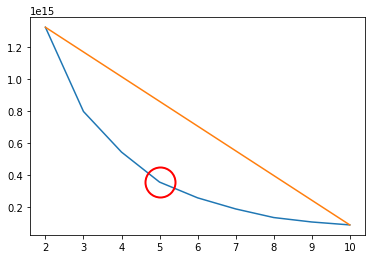

In [13]:
# Plot Information dataset Elbow

# From 2 clusters 
print("Plot for IDS: ")

plt.plot(range(2,11), score_list_ids[1:])
plt.plot([2, 10],[score_list_ids[1], score_list_ids[9]])
plt.plot(5, score_list_ids[4], 'o', ms=30, mec='r', mfc='none', mew=2)



We compute the distance from the line on graph between the sum of squared error.

In [14]:
distances = {}

p1=np.array([2,score_list_ids[1]])
p2=np.array([10,score_list_ids[9]])

for i in range(1,10):
    p3 = np.array([i+1,score_list_ids[i]])
    d = abs(np.cross(p2-p1,p3-p1)/np.linalg.norm(p2-p1))
    distances[i+1] = d
distances

{2: 0.0,
 3: 2.408987910591576,
 4: 3.052858811967538,
 5: 3.26713046464527,
 6: 2.90405692234205,
 7: 2.352889452719834,
 8: 1.7014135586349814,
 9: 0.8811608971259987,
 10: 0.0}

##### As you can see, the optimal number of clusters is 5

## 4) Comparison among cluster

### Cluster the listings in information and description dataset by using the optimal cluster count obtained from the Elbow method

### Find similar clusters


In [1]:
#%%writefile code/cluster_listings.py

# data - is the dataset
# k  - number of clusters
# @TODO: Need to use Elbow method to decide on
# Optimal number of clusters

def cluster_documents(data, k):   
    
    #use k-means to clusterize the songs
    kmeans = KMeans(n_clusters=k, init='random') # initialization
    kmeans.fit(data) # actual execution
    c = kmeans.predict(data)
    c_list = list(c)

    clustered_list = []

    # Creating a multi dimentional array based on k
    for c in range(k):
        clustered_list.append([])

    # Extract the listing ids from indexes
    index = 0
    for i in c_list:
        clustered_list[i].append(index)
        index += 1
    
    return clustered_list

# @TODO: Based on the optimial cluster count from Elbow method
print('Clustering for Information Dataset: ')
ids_c_list = cluster_documents(information_ds_persist['dataset'], 5)


print('Clustering for Description Dataset: ')
dds_c_list = cluster_documents(description_ds_persist['dataset'], 5)

# Jaccard similarity
print('Applying Jacard similarity for the clusters: ')
cmp_output  = compare_clusters(ids_c_list, dds_c_list)


# Getting top 3 similar clusters and use it to generate wordcloud
top_3_tuple = sorted(zip(cmp_output['score_list'], cmp_output['comb_list']), reverse=True)[:3]
top_3_list = list(top_3_tuple)
print(top_3_list)

#Preparing the cluster list for generating word cloud
top_c_list = get_similar_clusters(top_3_list, ids_c_list, dds_c_list)

Clustering for Information Dataset: 


NameError: name 'information_ds_persist' is not defined

These are the top 3 similar clusters between information dataset and description dataset.

## 5) Word cloud of house descriptions

In [ ]:
#%%writefile code/create_wordcloud.py

def create_wordcloud(clist, stopwords_flag):

    c_index = 0   
    
    for cluster in clist:
        
        cur_cluster_words = " "
        
        # Extracting all the words of the listings in current cluster
        for list_id in cluster:
            cur_cluster_words +=  get_listing_content(list_id, stopwords_flag)
        
        #strg_cloud = ' '.join(strg_cloud.split())
        
        wordcloud = WordCloud(width = 300, height = 300, margin = 0, collocations=False).generate(cur_cluster_words)
        
        plt.imshow(wordcloud, interpolation = "bilinear")
        plt.axis("off")
        plt.margins(x=0,y=0)
        plt.savefig(get_wc_save_path(c_index, stopwords_flag))
        #plt.show()

        c_index += 1  


#Creating wordcloud with top 3 similar clusters
# Wordcloud with all the words
create_wordcloud(top_c_list, False)

# Wordcloud without stopwords
create_wordcloud(top_c_list, True)

## Results of wordcloud:

### We applied wordcloud to 2 sets of data, 
#### 1) without stopwords 
#### 2) with stopwords(all words)


## Without stopwords:


### Cluster 1

![title](wordcloud/cluster_0.png)


### Cluster 2

![title](wordcloud/cluster_1.png)


### Cluster 3

![title](wordcloud/cluster_2.png)


## With all the words:


### Cluster 1

![title](wordcloud/cluster_all_0.png)


### Cluster 2

![title](wordcloud/cluster_all_1.png)


### Cluster 3

![title](wordcloud/cluster_all_2.png)

![immobiliare.it](https://www.progedil90.it/blog/wp-content/uploads/2015/12/crescita-mercato-immobiliare-italia-2015.jpg)

# 2) Find the duplicates! 

### Welcome to the second part of this HomeWork!

The goal of this section of HW4 was define a hash function that associates a value to each string to check whether there are some duplicate strings.We have two different ways,that we'll explain you later..
Now we wanna try to explain what does hashing algorithm really mean.
The point of a hash value is that it is theoretically impossible to find the original input number without knowing the hashing algorithm used to create the eventual hash.


![HASSSHH](https://blog.cex.io/wp-content/uploads/2014/10/Hashing-Algorhitm_Blog1.png)

### THE GOOAL!

There are 3 steps that you need to perform:
- Convert the string containing the password to a (potentially large) number
- Use a hash function to map the number to a large range.
- find if two numbers fall on the same range.

### How big is our file??

In [ ]:
# we can check how many rows this file have.
lunghezza=len(password)
print(lunghezza,'?','one hundred and ten million lines? are we kidding?')

![Huge](https://media.makeameme.org/created/what-is-that-5b3c88.jpg)

Ok, let's go!

In [ ]:
with open('passwords2.txt')as file: # read file .txt 
    password = file.readlines()
for count in range(len(password)):
    password[count] = password[count].replace("\n","")# for each line we have replaced "\n" with ""

First of all we opened the passwords2.txt file, but only in Reading mode, we red the file line for line, where the lines were strings.

### I° option, order doesn't matter..
-  Associate a number to strings,  but in this case the  order is not important.For istance , "AABA" = "AAAB" , these strings will have the same number. 

### II° option, order is important..
-  Associate a number to strings,  but now the  order IS IMPORTANT.For istance , "AABA" != "AAAB" now will have the different numbers.



Let's go with the first case.

In [ ]:
# without order
def MYHASH1(password):
    count = 1
    for elem in password:
        count = (count  ^ (ord(elem)*(7*37**17-27) << 2))
    count % (2**128)
    return count

In [ ]:
print((MYHASH1('ciao')),' is equal to ',MYHASH1('icao'),'?')
print(MYHASH1('oaic')== MYHASH1('ciao'))
print((MYHASH1('oaic')),' is different to ',MYHASH1('ciao'),'?')
print(MYHASH1('oaic')!= MYHASH1('ciao'))
print((MYHASH1('CIAONE')),' and ',MYHASH1('CIAONE2'),' are the same ?')
print(MYHASH1('CIAONE')== MYHASH1('CIAONE2'))

some tests to verify that our algorithm works...
Well done!

### improve no collisions probability !
Quite often the above mentioned polynomial hash is good enough, and no collisions will happen during tests with a small number of strings.  What if we compared a strings
with 110000000 million of different strings?.Now the probability increase, it is pretty much guaranteed that this task will end will a collision and returns the wrong result.
But we found a really easy trick to get better probabilities. We can just compute two different hashes for each string (by using two different P, and/or different m, and compare these pairs instead. If for istance, at the beginning the probability that collisions appear was ${10}^{-9}$ now will be ${10}^{-18}$

Different strings with each other (e.g. by counting how many unique strings exists), then the probability of at least one collision happening is already ≈1


In [ ]:

def Double_(password):
    MyDict = dict()
    coll = 0 
    double= 0
    with open('passwords2.txt', 'r') as f: 
        for i, line in enumerate(f):
            check = password(line)
            if check in MyDict.keys():
                double += 1 
                if sorted(MyDict[check]) != sorted(line):
                    coll += 1
            else:
                MyDict[check] = line
    f.close()
    return (coll,double)


In [ ]:
coll,double = Double_(MYHASH1)

In [ ]:
print("there are", coll,'collisions','and', double,'duplicates')

pretty good, 10 M duplicates and no Collisions,just as we expected.
We used a Collision resistance Algorithm , ‘cryptographic hash function’ H are:

- Collision resistance: It is hard to find two messages:
Collision resistance is a property of cryptographic hash functions: a hash function H is collision resistant if it is hard to find two inputs that hash to the same output; that is, two inputs a and b such that $H(a) = H(b)$, and $a$ different from  $b$
- Preimage resistance: Given a hash h:
Preimage resistance is about the most basic property of a hash function which can be thought. It means:For a given h in the output space of the hash function, it is hard to find any message x with $H(x)=h$.
- Second-preimage resistance: Given a message x:
the hash function H′constructed as suggested is such that for any preimage m1, there is a different preimage m2 with the same hash, obtained from the first by complementing the added input bit b, and the other input bit which is combined with b.



Now we can analyze the second case.

In [ ]:
def MYHASH2(password):
    p = 151
    
    m = 14484968830081
    hash_value = 0
    p_pow = 1
    for i, char in enumerate(password):
        hash_value = (hash_value + ord(char) * p_pow) % m
        p_pow = (p_pow * p) % m
    
    return hash_value

In [ ]:
print((MYHASH2('ciao')),' is equal to ',MYHASH2('icao'),'?')
print(MYHASH2('oaic')== MYHASH2('ciao'))
print((MYHASH2('oaic')),' is different to ',MYHASH2('ciao'),'?')
print(MYHASH2('oaic')!= MYHASH2('ciao'))
print((MYHASH2('CIAONE')),' and ', MYHASH2('CIAONE2'),' are the same ?')
print(MYHASH2('CIAONE')== MYHASH2('CIAOEN'))

In [ ]:

# with order
m = [0] * 14484968830081

coll = 0
double = 0

for i in password:
    x = MYHASH2(i)
    go_to= x % 14484968830081
    if m[go_to] == 0:
        m[go_to] = [i]
    elif i in m[go_to]:
        double += 1
    else:
        m[go_to].append(i)
        coll += 1
print(coll,double)

In [ ]:
print("there are", coll,'collisions','and', double,'duplicates')

### Our Conclusion(s)

Suppose you were able to find two different strings that created the same output (a collision) .
Then, at some factory during the process, you would be inputting two different strings and that particular factory would return the same output for both lines.
But this means that you have found a collision at one factory, and this is a contradiction !For any hashing algorithm to be successful, it needs to be easy to create an output but impossible to find an input. In other words, in this homework we converted each string to number. For istance if you know that the hash value is 144 and the algorithm used was to multiple the input number by 12, it becomes easy to find that the original input number was 12. On the other hand, imagine if the input number could be a list of numbers that are added together before they’re multiplied by 12. This means that the input numbers could now be [12], [2,4,6], [3,3,3,3], or any other list of numbers that adds up to 12. With this hashing function, it becomes much more difficult to find the original input number when the hash algorithm and hash value are all you have.
We implemented our hash Functions to find the duplicates in both cases.In the first case we discovered 10M duplicates and no collisions, because we used a Collision resistance Algorithm. in the second case, we found 5M duoplicates, the half of before,and this was rather obvious because now we know that each string "SHOULD" have a different number. As you can see also for the second part we have 0 collisions, and this is very good, but we know it because our algorithm is collision resistant.